In [2]:
import sys
import pandas as pd
import pickle
import numpy as np

sys.path.append("../code/")
from fitting import fit_gsize_dist, fit_gtrans_mat
from utils import change_width, centered_np_hist

### Reading model results and computing distances with empirical observables

Reading the dataframe containing the parameters of the model explored

In [3]:
#Reading the parameter dataframe
PATH = 'results/'

pars_df = pd.read_csv(PATH+'parameters.csv')
pars_df.set_index('pars_id', inplace=True)
pars_df.head()

,N,t_max,beta,alpha,n0,L,epsilon
pars_id,,,,,,,
0,700,2000,0.8,0.05,3.0,1.0,1
1,700,2000,0.8,0.05,3.0,1.0,5
2,700,2000,0.8,0.05,3.0,1.0,10
3,700,2000,0.8,0.05,3.0,1.0,15
4,700,2000,0.8,0.05,3.0,1.0,20


Loading empirical data

In [4]:
dataset = 'CNS'
context = 'out-of-class'

IN_PATH = '../data-analysis/results/%s/'%dataset

#Group size distribution
FNAME = 'Pk_%s.csv'%context
Pk_emp = pd.read_csv(IN_PATH+FNAME)

#Group transition matrix
FNAME = 'T_%s.csv'%context
T_emp = pd.read_csv(IN_PATH+FNAME)

Computing Jensen-Shannon divergence of group size distributions

In [5]:
MODEL_IN_PATH = 'results-gsize-dist/'

fit_df = fit_gsize_dist(Pk_emp, pars_df, MODEL_IN_PATH, log=False)
fit_df.head()

,N,t_max,beta,alpha,n0,L,epsilon,JSD_gsize
pars_id,,,,,,,,
0,700,2000,0.8,0.05,3.0,1.0,1,0.746088
1,700,2000,0.8,0.05,3.0,1.0,5,0.687307
2,700,2000,0.8,0.05,3.0,1.0,10,0.648506
3,700,2000,0.8,0.05,3.0,1.0,15,0.619802
4,700,2000,0.8,0.05,3.0,1.0,20,0.600212


Same but with log10 first

In [6]:
fit_df = fit_gsize_dist(Pk_emp, fit_df, MODEL_IN_PATH, log=True)
fit_df.head()

,N,t_max,beta,alpha,n0,L,epsilon,JSD_gsize,JSD_gsize_log
pars_id,,,,,,,,,
0,700,2000,0.8,0.05,3.0,1.0,1,0.746088,0.701413
1,700,2000,0.8,0.05,3.0,1.0,5,0.687307,0.704333
2,700,2000,0.8,0.05,3.0,1.0,10,0.648506,0.696359
3,700,2000,0.8,0.05,3.0,1.0,15,0.619802,0.699881
4,700,2000,0.8,0.05,3.0,1.0,20,0.600212,0.692102


Computing Jensen-Shannon divergence of the group transition matrix

In [7]:
MODEL_IN_PATH = 'results-gtrans-mat/'

fit_df = fit_gtrans_mat(T_emp, fit_df, MODEL_IN_PATH, weighted=False, k_cut="max")
fit_df.head()

,N,t_max,beta,alpha,n0,L,epsilon,JSD_gsize,JSD_gsize_log,JSD_T
pars_id,,,,,,,,,,
0,700,2000,0.8,0.05,3.0,1.0,1,0.746088,0.701413,9.574770
1,700,2000,0.8,0.05,3.0,1.0,5,0.687307,0.704333,9.274985
2,700,2000,0.8,0.05,3.0,1.0,10,0.648506,0.696359,9.138381
3,700,2000,0.8,0.05,3.0,1.0,15,0.619802,0.699881,9.069468
4,700,2000,0.8,0.05,3.0,1.0,20,0.600212,0.692102,9.024133


Saving

In [8]:
OUT_PATH = 'results/'
FNAME = 'parameters_fit.csv'

fit_df.to_csv(OUT_PATH+FNAME, header=True, index=False)

### Joint minimization

In [10]:
IN_PATH = 'results/'
FNAME = 'parameters_fit.csv'

fit_df = pd.read_csv(IN_PATH+FNAME)
fit_df.head()

,N,t_max,beta,alpha,n0,L,epsilon,JSD_gsize,JSD_gsize_log,JSD_T
0,700,2000,0.8,0.05,3.0,1.0,1,0.746088,0.701413,9.574770
1,700,2000,0.8,0.05,3.0,1.0,5,0.687307,0.704333,9.274985
2,700,2000,0.8,0.05,3.0,1.0,10,0.648506,0.696359,9.138381
3,700,2000,0.8,0.05,3.0,1.0,15,0.619802,0.699881,9.069468
4,700,2000,0.8,0.05,3.0,1.0,20,0.600212,0.692102,9.024133


In [13]:
import plotly.express as px

fig = px.scatter_3d(fit_df, x='alpha', y='n0', z='epsilon',
                    color='JSD_T', size='JSD_T')
fig.show()

In [14]:
import plotly.express as px

fig = px.scatter_3d(fit_df, x='alpha', y='n0', z='epsilon',
                    color='JSD_gsize', size='JSD_gsize')
fig.show()

Joint minimization

In [13]:
#Mixing the two JSDs with the mixing parameter mu
mu=0.5
fit_df['mixed_div'] = mu*fit_df['JSD_gsize_log']+(1-mu)*(fit_df['JSD_T'])

best_ID = fit_df[['mixed_div']].idxmin()
print("ID of best set of parameters:", best_ID)
fit_df.iloc[best_ID]

ID of best set of parameters: mixed_div    169
dtype: int64


,N,t_max,beta,alpha,n0,L,epsilon,JSD_gsize,JSD_gsize_log,JSD_T,mixed_div
169,700,2000,0.8,0.4,9.0,1.0,5,0.598598,0.167934,2.511453,1.339693


Plotting results associated to the best fit

In [15]:
import matplotlib.pyplot as plt
import palettable as pltt
import seaborn as sns
import matplotlib as mplt

In [19]:
#Reading model results
IN_PATH = "results-gsize-dist/"
FNAME = "Pk_pars_id%i.csv"%best_ID
Pk_model = pd.read_csv(IN_PATH+FNAME)

IN_PATH = "results-gtrans-mat/"
FNAME = "T_pars_id%i.csv"%best_ID
T_model = pd.read_csv(IN_PATH+FNAME)

cmaps = {'out-of-class': pltt.colorbrewer.sequential.Blues_4.get_mpl_colormap()}
cmap = [cmaps['out-of-class'](ii / len(Pk_model)) for ii in range(len(Pk_model))]

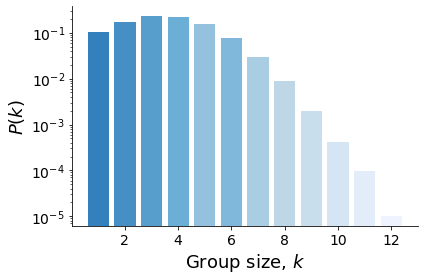

In [21]:
ax = plt.subplot(111)

ax.bar(Pk_model['k'], Pk_model['Pk'], color=cmap[::-1])

ax.set_yscale('log')
ax.set_xlabel('Group size, $k$', size=18)
ax.set_ylabel('$P(k)$', size=18)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.tight_layout()

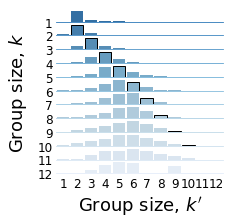

In [22]:
k_max = 12
color = pltt.colorbrewer.sequential.Blues_4.mpl_colors[2]
cmap = pltt.colorbrewer.sequential.Blues_4_r.get_mpl_colormap()

#Cleaning the matrices since some groups don't appear... TO BE ADJUSTED IN THE FUTURE, IF NEEDED
dfx = T_model[(T_model['k(t)']<=k_max)&(T_model['k(t+1)']<=k_max)]

fig, axes = plt.subplots(k_max, 1, sharex=True, figsize=(k_max/4, k_max/4))

#Creating the big plot that contains the others
fig.add_subplot(111, frameon=False)
#hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel(r'Group size, $k$', size=18)

for ii, k in enumerate(dfx['k(t+1)'].unique()):
    ax=axes[ii]
    sns.barplot(ax=ax, data=dfx[dfx['k(t)']==k], x='k(t+1)', y='Prob.',
                color=cmap(ii / len(dfx['k(t+1)'].unique())))#color=colors[context])
    #changing bar width
    change_width(ax, .9)
    #Coloring the edge of the diagonal
    ax.patches[k-1].set_edgecolor('black')

    if k==k_max:
        ax.set_xlabel(r'Group size, $k^{\prime}$', size=18)
    else:
        ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([0])
    ax.set_yticklabels([k])
    ax.tick_params(axis='both', which='major', labelsize=12, length=0, rotation=0)
    sns.despine(top=True, left=True)
    ax.spines['bottom'].set_color(cmap(ii / len(dfx['k(t+1)'].unique())))#colors[context])